## To classify the image as Alien or Predator using Transfer Learning(VGG16)

Download the dataset : https://www.kaggle.com/pmigdal/alien-vs-predator-images

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Load all the required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from glob import glob
import cv2

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.callbacks import *
from keras.models import load_model, model_from_json

Display some images of Predators

Random images of Predator


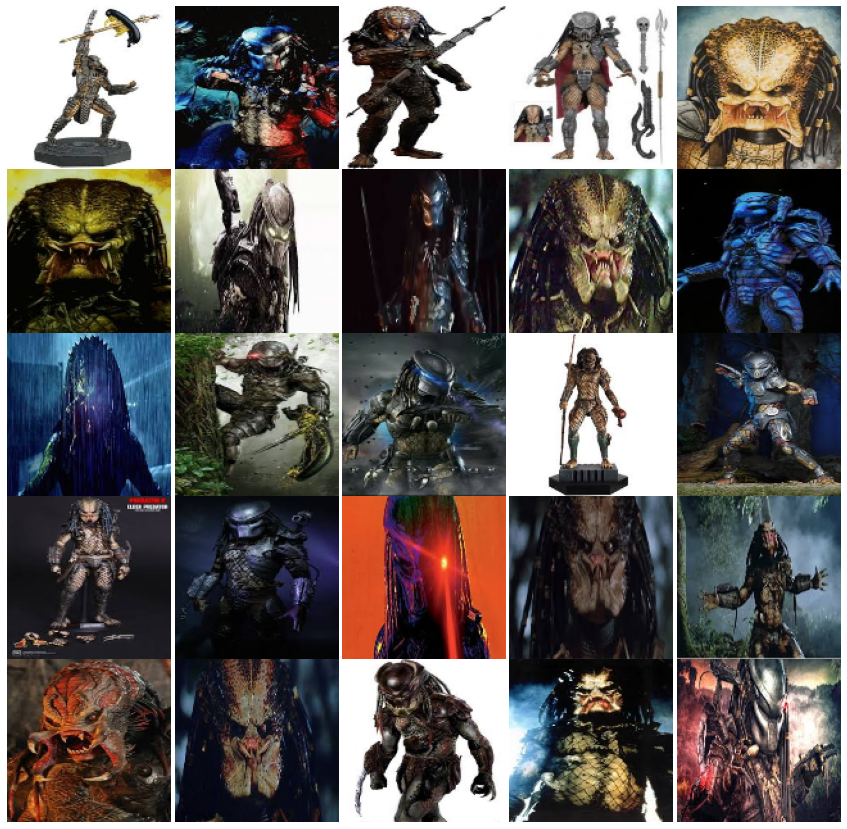

In [3]:
def plotImages(artist,directory):
    print(artist)
    multipleImages = glob(directory)
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for l in multipleImages[:25]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128)) 
        plt.subplot(5, 5, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1
        
        
plotImages("Random images of Predator","../input/alien-vs-predator-images/data/train/predator/**") 

Display some images of Alien

Random images of Alien


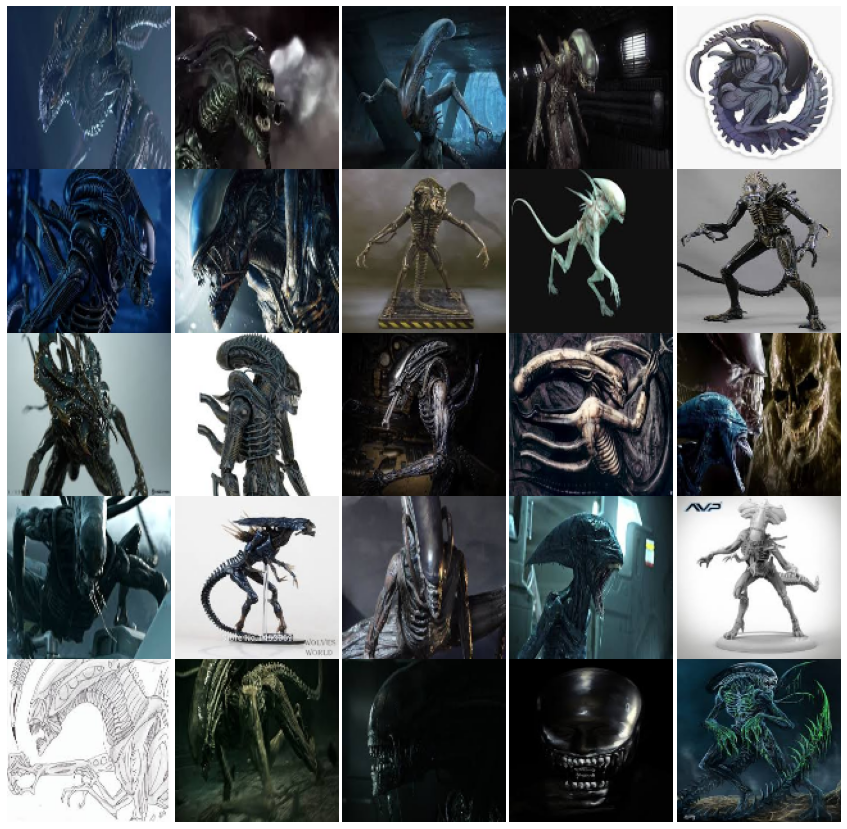

In [4]:
def plotImages(artist,directory):
    print(artist)
    multipleImages = glob(directory)
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for l in multipleImages[:25]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128)) 
        plt.subplot(5, 5, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1
        
        
plotImages("Random images of Alien","../input/alien-vs-predator-images/data/train/alien/**") 

In [5]:
# re-size all the images to this
train_input_shape = (224, 224, 3)

In [6]:
train_path = '../input/alien-vs-predator-images/data/train/'
valid_path = '../input/alien-vs-predator-images/data/validation/'

**Build Model**

So here in this part we are going to build model which train our data using state of the art technique like VGG16 model. I can use CNN(Convolutional Neural Network) but when I read the research paper that VGG16 network does a tremendous job on image data so let’s begin this section.

VGG16 model is also called identity layer why because the sole purpose of identity layer is skip-connection that means skip one layer in VGG16 model which helps reducing vanishing gradient problem

The VGG16 model is adapted to the 1000 categories of ImageNet. Our task, however, is to classify the images as alien or predator.

What can we do? With keras, it's easy to import only the convolutional part of VGG16, by setting the include_top parameter to False :

In [7]:
# # Load pre-trained VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=train_input_shape)

58892288/58889256 [==============================] - 0s 0us/step


In [8]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

**Create a CNN network**

In [9]:
# our layers - you can add more if you want
x = vgg.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x) # 2 since we have only 2 categories

In [10]:
model = Model(vgg.input, predictions)

In [11]:
# create a model object
model = Model(inputs=vgg.input, outputs=predictions)

# view the structure of the model
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

**Tell the model what cost and optimization method to use**

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

**Data Augmentation**

Data Augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. This technique like padding , cropping , shifting , flipping etc.

**ImageDataGenerator()** the ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   preprocessing_function=preprocess_input)

training_generator = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')


test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**Put early stopping criteria**

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

**Train the model**

In [15]:
#Train the model
r = model.fit_generator(
  generator = training_generator,
  validation_data = test_generator,
  epochs = 25,
  shuffle=True,
  steps_per_epoch = 347 // 32,
  validation_steps = 10,
  use_multiprocessing=True,
  callbacks = early_stop
)

Epoch 1/25
10/10 [==============================] - 8s 789ms/step - loss: 0.7772 - accuracy: 0.4938 - val_loss: 1.1165 - val_accuracy: 0.7196
Epoch 2/25
10/10 [==============================] - 9s 941ms/step - loss: 0.5970 - accuracy: 0.7094 - val_loss: 1.1972 - val_accuracy: 0.7905
Epoch 3/25
10/10 [==============================] - 10s 962ms/step - loss: 0.5107 - accuracy: 0.8125 - val_loss: 2.1705 - val_accuracy: 0.7432
Epoch 4/25
10/10 [==============================] - 10s 1s/step - loss: 0.4440 - accuracy: 0.8387 - val_loss: 3.0172 - val_accuracy: 0.7500
Epoch 5/25
10/10 [==============================] - 10s 991ms/step - loss: 0.3938 - accuracy: 0.8562 - val_loss: 2.9306 - val_accuracy: 0.7703
Epoch 6/25
10/10 [==============================] - 9s 919ms/step - loss: 0.3424 - accuracy: 0.8774 - val_loss: 4.0054 - val_accuracy: 0.7635
Epoch 7/25
10/10 [==============================] - 10s 974ms/step - loss: 0.3251 - accuracy: 0.8903 - val_loss: 4.4820 - val_accuracy: 0.7635
Epoch

Text(0.5, 1.0, 'Accuracy')

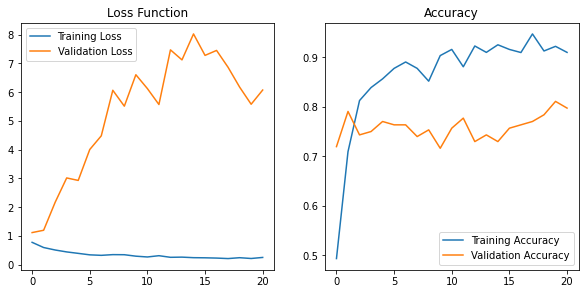

In [16]:
#Plot train and test loss and Accuracy
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Function')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

**Save and load the model**

This is for demonstration. You don't need to to so, if you intend to run predictions within this notebook.

In [20]:
!mkdir models
!mkdir models/keras

In [21]:
# save
model.save('models/keras/model.h5')

In [22]:
# load
model = load_model('models/keras/model.h5')

In [23]:
# save
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
        f.write(model.to_json())

In [24]:
# load
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')


**Make prediction on random test images**

In [26]:
validation_img_paths = ["alien/22.jpg",
                        "predator/33.jpg",
                       "predator/65.jpg",
                       "alien/60.jpg",
                       "alien/30.jpg",
                       "predator/3.jpg"]
img_list = [Image.open(valid_path + img_path) for img_path in validation_img_paths]

In [27]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [28]:
pred_probs = model.predict(validation_batch)
pred_probs

array([[8.3191657e-01, 1.6808349e-01],
       [2.8474467e-06, 9.9999714e-01],
       [7.8212105e-02, 9.2178786e-01],
       [9.6664298e-01, 3.3357069e-02],
       [9.9805284e-01, 1.9471592e-03],
       [1.1776593e-04, 9.9988222e-01]], dtype=float32)

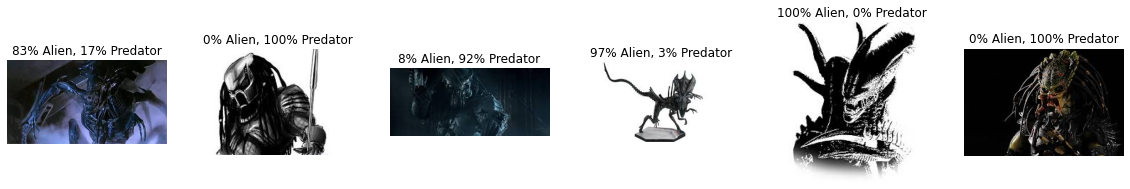

In [29]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)